# Universal differential equation for the SEIR model

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(10);

### Define the SEIR dynamics and solve the ODE

In [2]:
function seir!(du, u, p, t)
    α, β, γ, N = p
    du[1] = -β*u[1]*u[3]/N
    du[2] = β*u[1]*u[3]/N - α*u[2]
    du[3] = α*u[2] - γ*u[3]
    du[4] = γ*u[3]
end

p_ODE = [0.3, 1.0, 0.4, 1.0]
u0 = [0.995, 0.004, 0.001, 0.0]
tspan = (0.0, 50.0);

In [3]:
prob = ODEProblem(seir!, u0, tspan, p_ODE)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

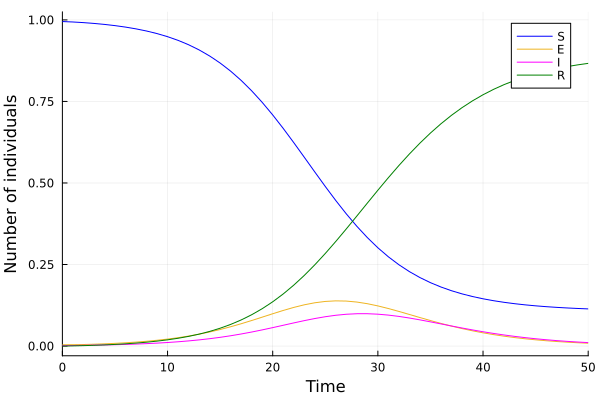

In [4]:
plot(sol, xlabel = "Time", ylabel = "Number of individuals", labels = ["S" "E" "I" "R"], 
     color = [:blue :goldenrod2 :magenta :green])

### Add multiplicative log-normal noise

In [5]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.05)
noise = rand(rng, dist, size(X[:, begin:5:end]))
X_noisy = noise .* X[:, begin:5:end];

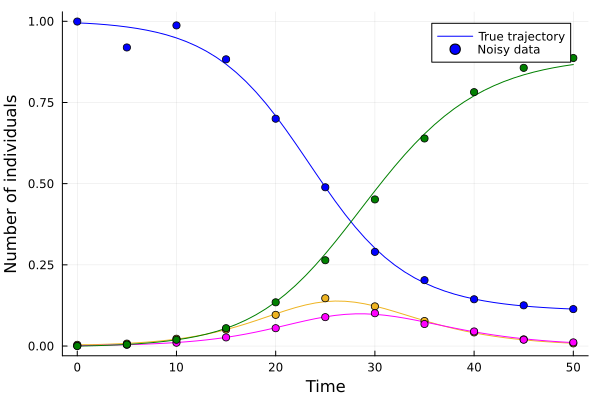

In [6]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :goldenrod2 :magenta :green], 
     label = ["True trajectory" nothing nothing nothing])
scatter!(t[begin:5:end], X_noisy', color = [:blue :goldenrod2 :magenta :green], 
     label = ["Noisy data" nothing nothing nothing])

### Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u)+\text{NN}(u)$.

In [7]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))   

# Multi-layer feed-forward neural network
model = Chain(Dense(4, 8, rbf), Dense(8, 8, rbf), Dense(8, 8, rbf), Dense(8, 4))

# Get initial parameters and state variables of the model
p_init, st = Lux.setup(rng, model);

In [8]:
# Define the hybrid model
α, β, γ, N = p_ODE

function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = nn[2] 
    du[3] = -γ*u[3] + nn[3]
    du[4] = γ*u[3] + nn[4]
end

prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### Set up the training

In [9]:
function predict(p, saveat = t[begin:5:end])   # p is the parameter of the NN and the ODE at the same time
    _prob = remake(prob_ude, p = p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = saveat,
                sensealg = QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [10]:
function loss(p)
    X̂ = predict(p)
    mean(abs2, X_noisy .- X̂)   # MSE loss
end;

In [11]:
losses = Float64[]

function callback(p, l)
    push!(losses, l)
    n_iter = length(losses)
    if n_iter % 50 == 0   
        println("Loss after $(n_iter) iterations: $(losses[end])")
    end
    return false
end;

### Train the UDE

In [12]:
adtype = AutoZygote()   # automatic differentiation
optf = OptimizationFunction((p, _) -> loss(p), adtype)
optprob = OptimizationProblem(optf, ComponentVector{Float64}(p_init));

In [13]:
res1 = solve(optprob, ADAM(), callback = callback, maxiters = 5000);

Loss after 50 iterations: 51.252097598562955
Loss after 100 iterations: 3.8295740845981396
Loss after 150 iterations: 2.044814472047759
Loss after 200 iterations: 1.06520859658241
Loss after 250 iterations: 0.7975340752741643
Loss after 300 iterations: 0.4965636937325541
Loss after 350 iterations: 0.30731559324896146
Loss after 400 iterations: 0.21789568944211046
Loss after 450 iterations: 0.168676266156095
Loss after 500 iterations: 0.1361162060156591
Loss after 550 iterations: 0.11212302165148987
Loss after 600 iterations: 0.09357521123724762
Loss after 650 iterations: 0.07895951865397344
Loss after 700 iterations: 0.06739716265336083
Loss after 750 iterations: 0.058246052625826335
Loss after 800 iterations: 0.05096931694391385
Loss after 850 iterations: 0.0451242829118287
Loss after 900 iterations: 0.04036415151839275
Loss after 950 iterations: 0.03642700626636271
Loss after 1000 iterations: 0.03311859467126402
Loss after 1050 iterations: 0.030295728649751965
Loss after 1100 iterati

In [14]:
optprob2 = OptimizationProblem(optf, res1.u)
res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = 1500)
p_trained = res2.u;

Loss after 5050 iterations: 0.0005522795466767744
Loss after 5100 iterations: 0.00043997389504786885
Loss after 5150 iterations: 0.00040320730817376417
Loss after 5200 iterations: 0.00037700747682938214
Loss after 5250 iterations: 0.00036669802585385654
Loss after 5300 iterations: 0.00036169238688987245
Loss after 5350 iterations: 0.00035498996577706287
Loss after 5400 iterations: 0.0003526274737144017
Loss after 5450 iterations: 0.0003451992499778546
Loss after 5500 iterations: 0.0003370101570545883
Loss after 5550 iterations: 0.0003350547950022433
Loss after 5600 iterations: 0.00033321455465356583
Loss after 5650 iterations: 0.0003319397845473948
Loss after 5700 iterations: 0.000329152026326333
Loss after 5750 iterations: 0.00032719089836617755
Loss after 5800 iterations: 0.0003217367723709064
Loss after 5850 iterations: 0.0003180533543361321
Loss after 5900 iterations: 0.00031509379055981966
Loss after 5950 iterations: 0.00031441141762141484
Loss after 6000 iterations: 0.00031042757

### Visualize the results

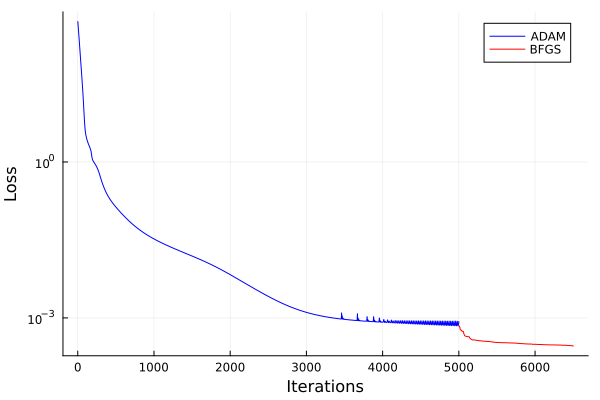

In [15]:
plot(1:5000, losses[1:5000], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM", color=:blue)
plot!(5001:length(losses), losses[5001:end], yaxis=:log10, label="BFGS", color=:red)

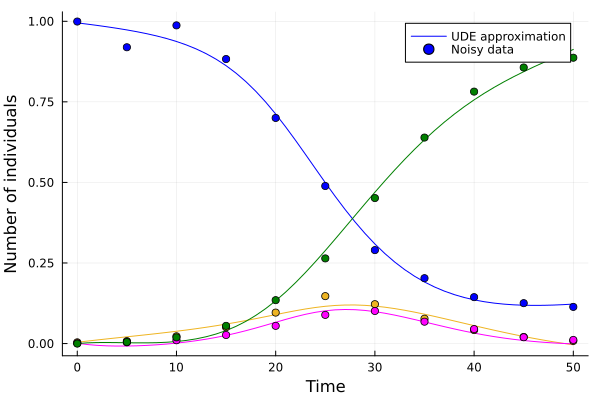

In [16]:
X̂ = predict(p_trained, t)
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :goldenrod2 :magenta :green],
     label = ["UDE approximation" nothing nothing nothing])
scatter!(t[begin:5:end], X_noisy', color = [:blue :goldenrod2 :magenta :green], 
     label = ["Noisy data" nothing nothing nothing])

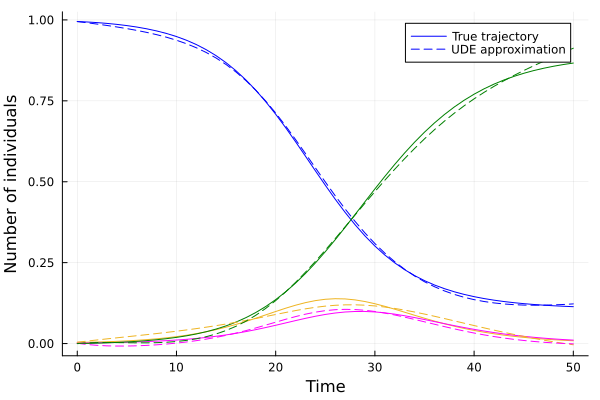

In [17]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :goldenrod2 :magenta :green], 
     label = ["True trajectory" nothing nothing nothing])
plot!(t, X̂', color = [:blue :goldenrod2 :magenta :green], linestyle = :dash, 
     label = ["UDE approximation" nothing nothing nothing])

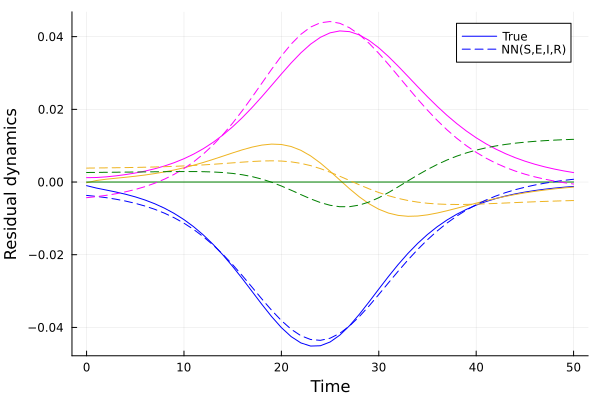

In [18]:
# True residual dynamics (i.e. interactions of predictors) along the true trajectory
dynamics_true = [-β/N*(X[1,:].*X[3,:])'; β/N*(X[1,:].*X[3,:])'-α*X[2,:]'; α*X[2,:]'; zeros(length(t))']
# Neural network guess along the true trajectory
dynamics_nn = Lux.apply(model, X, p_trained, st)[1]

plot(t, dynamics_true', xlabel = "Time", ylabel = "Residual dynamics", color = [:blue :goldenrod2 :magenta :green], 
     label = ["True" nothing nothing nothing])
plot!(t, dynamics_nn', color = [:blue :goldenrod2 :magenta :green], linestyle = :dash, 
     label = ["NN(S,E,I,R)" nothing nothing nothing])